In [1]:
%matplotlib inline
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Load top20products sales dataset

In [2]:
# load data and convert to datetime
df = pd.read_csv('../data-processed/orderproducts_top20.csv', parse_dates=[1], infer_datetime_format=True)
prod_monthly = pd.crosstab(df['order_date'], df['product_sku']).resample('M').sum()  # resample data to monthly numbers
prod_monthly = prod_monthly['2018-01':'2021-03'] 
prod_monthly.head()

product_sku,EFX-FLY-BLK,M80-2B-BLK,M80-2G-BLK,M80-AC-BLK,M80-AD-BLK,M80-BTY-BLK-L,M80-BTY-BLK-S,M80-EB-BLK,M80-EG-BLK,M80-SEB-BLK,M80-SEG-ASH,M80-SEG-BLK,M80-TICK-V2-BLK,M80-TOUR-V2-BLK,M80-VAD-BLK,M80-VEB-BLK,M80-VEB-GRY,M80-VEG-BLK,M80-VEG-GRY,M80-VHB-BLK
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-31,16,12,22,12,15,11,8,11,17,27,12,15,25,16,14,8,15,33,5,18
2018-02-28,24,9,13,10,5,12,3,22,24,14,15,13,24,22,6,6,12,7,3,7
2018-03-31,21,6,7,0,16,14,6,13,14,2,4,11,16,14,6,14,5,6,9,18
2018-04-30,39,25,37,22,22,26,20,26,35,28,31,31,35,19,25,35,17,100,29,38
2018-05-31,27,10,23,11,17,14,6,13,21,10,14,13,18,18,9,17,12,19,4,14


#### To analyse one timeseries - ['EFX-FLY-BLK']

In [3]:
monthly_temp = prod_monthly[['EFX-FLY-BLK']]
monthly_temp.describe()

product_sku,EFX-FLY-BLK
count,39.000000
mean,11.743590
std,9.962345
min,0.000000
25%,4.500000
50%,9.000000
75%,14.000000
max,39.000000


<AxesSubplot:xlabel='order_date'>

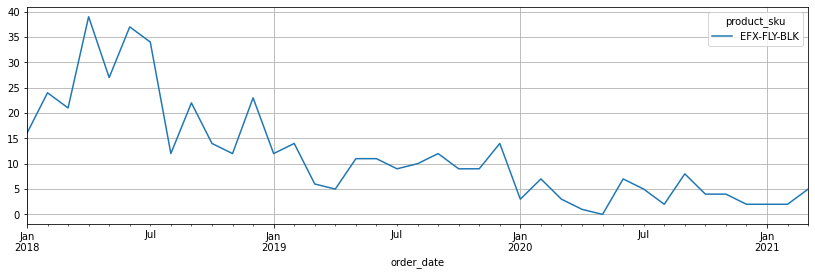

In [4]:
# Plot series
plt.rcParams['figure.figsize'] = [14, 4]
monthly_temp.plot(grid=True)

Are these datasets stationary? We can look at a few things per the list above:
- including a visual check (there is a downward trend for the monthly figures, weekly number maybe too small to assess), 
- a standard deviation check on various differences (smallest one is usually most stationary), 
- the formal Dickey-Fuller test.

In [5]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic          -3.170695
p-value                  0.021745
Lags Used                5.000000
Observations Used       33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
dtype: float64


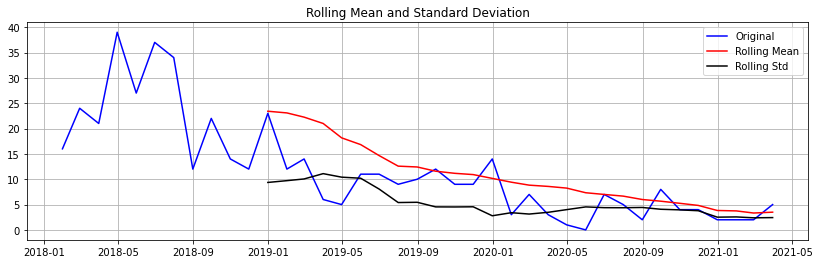

In [6]:
plt.rcParams['figure.figsize'] = [14, 4]
# run DFT on monthly
dftest(monthly_temp['EFX-FLY-BLK'])
# p-value allows us to reject a unit root: data is stationary

The t-statistics is greater that 1% critical value and p-value is less than 0.05. However the rolling mean is sliding which means there is a downward trend for this series.

- The t-statistics of -10.6 is less than 1% CF
- The p-value of 5.4e-19 is less than 0,05
- The rolling means is almost at 0 which shows no trends in the series
We can therefore reject the null hypothesis as non-stationary (i.e. the data is stationary).

#### Forecasting with Rolling Moving Average on one item

In [7]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))  # insert np.zeros(3) from index 0
    else:
        return cumulative_sum[window - 1:] / window

In [8]:
data  = prod_monthly['EFX-FLY-BLK']
train = data[:-3]
test  = data[-3:]
mth_yr = data.index
period = 3

smoothed_trend = moving_average(np.array(data), window=3, forecast=True)
forecast = np.empty(3)
forecast.fill(round(np.array(train[-3:]).mean()))

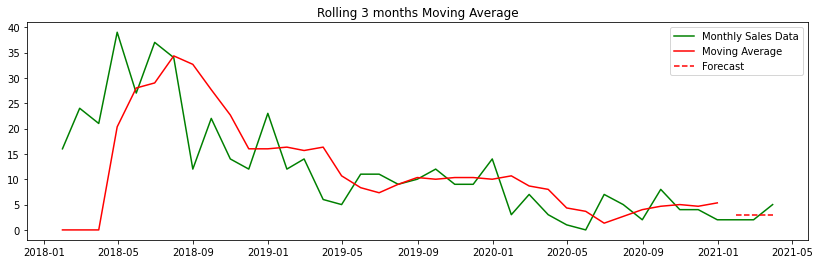

In [9]:
plt.plot(mth_yr, data, 'g', label='Monthly Sales Data')
plt.plot(mth_yr[:-3], smoothed_trend[:-4], 'r', label="Moving Average")
plt.plot(mth_yr[-3:], forecast, 'r--', label="Forecast")
plt.title('Rolling 3 months Moving Average')
plt.legend();

#### Forecast the last 3 month sales for the top 20 items

In [10]:
prod_monthly = pd.crosstab(df['order_date'], df['product_sku']).resample('M').sum()
prod_monthly = prod_monthly['2018-01':'2021-03']
items = prod_monthly.columns.values

# items are the names of the top20 items
test_predict = []
mse_list = []
results =  pd.DataFrame()

for item in items:
    data = prod_monthly[item]
    train = np.array(data.iloc[:-3])
    test  = np.array(data.iloc[-3:])
    mth_yr = data.index
    forecast = np.empty(3)
    forecast.fill(int(np.array(train[-3:]).mean()))    
    adj_forecast = [ 0 if x < 0 else int(round(x)) for x in list(forecast) ]
    item_name = [item for x in range(3)]
    res = pd.DataFrame(zip(test, adj_forecast, item_name), 
                       index=['m+1','m+2','m+3'], columns=['test', 'adj_forecast', 'item'])
    results = pd.concat([results,res], axis=0)
print(results)

     test  adj_forecast             item
m+1     2             3      EFX-FLY-BLK
m+2     2             3      EFX-FLY-BLK
m+3     5             3      EFX-FLY-BLK
m+1     1             3       M80-2B-BLK
m+2     1             3       M80-2B-BLK
m+3     1             3       M80-2B-BLK
m+1     5             4       M80-2G-BLK
m+2     4             4       M80-2G-BLK
m+3     5             4       M80-2G-BLK
m+1     0             3       M80-AC-BLK
m+2     0             3       M80-AC-BLK
m+3     1             3       M80-AC-BLK
m+1     3             2       M80-AD-BLK
m+2     1             2       M80-AD-BLK
m+3     0             2       M80-AD-BLK
m+1     3             1    M80-BTY-BLK-L
m+2     1             1    M80-BTY-BLK-L
m+3     1             1    M80-BTY-BLK-L
m+1     0             2    M80-BTY-BLK-S
m+2     2             2    M80-BTY-BLK-S
m+3     1             2    M80-BTY-BLK-S
m+1     3             0       M80-EB-BLK
m+2     1             0       M80-EB-BLK
m+3     1       

In [11]:
results.to_csv('../data-processed/top20forecasts_RollingMA_01to03.csv')